In [337]:
# Import all necessary libraries.
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor

In [406]:
# Utility functions.
def mod(V):
    ip = np.zeros((len(V),1),dtype=complex)
    inc = 0
    for v in V:
        if(v==0):
            ip[inc] = -1.0 - 1j*1.0
        elif(v==1):
            ip[inc] = -1.0 + 1j*1.0
        elif(v==2):
            ip[inc] = 1.0 - 1j*1.0
        else:
            ip[inc] = 1.0 + 1j*1.0
        inc += 1
    # Normalization of energy to 1.
    s = (1/np.sqrt(2))*ip;
    return s

def demod(c):
    c_seq = mod(np.array([2,0,3,1]))
    c_seq = c_seq[:,0]
    e = []
    for i in range(0,len(c_seq)):
        e.append(np.abs(c_seq[i] - c)**2)
    return e.index(np.min(e))

In [407]:
# Number of QPSK symbols to be transmitted.
N = 1000000

In [408]:
# Generate different random phases.
M = 513
phase = np.exp(1j*np.pi/np.arange(2,M))

phase_rnd = np.zeros((N,1),dtype=np.complex_)
for i in range(0,N):
    phase_rnd[i] = phase[np.random.randint(len(phase))]
    
theta_orig = np.arctan(phase_rnd.real/phase_rnd.imag)

In [409]:
# Define Es/N0 value in dB.
EsN0dB = 300
# Tranform into linear value.
EsN0Lin = 10.0**(-(EsN0dB/10.0))
    
# Generate N binary symbols.
ip = np.random.randint(0,4,(N,1))
    
# Modulate binary stream into QPSK symbols.
s = mod(ip)
    
# Generate noise vector. 
# Divide by two once the theoretical ber uses a complex Normal pdf with variance of each part = 1/2.
noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))
    
# Add phase error and pass symbols through AWGN channel.
y = s*phase_rnd + np.sqrt(EsN0Lin)*noise

# Phase of received signal.
theta = np.arctan(y.real/y.imag)

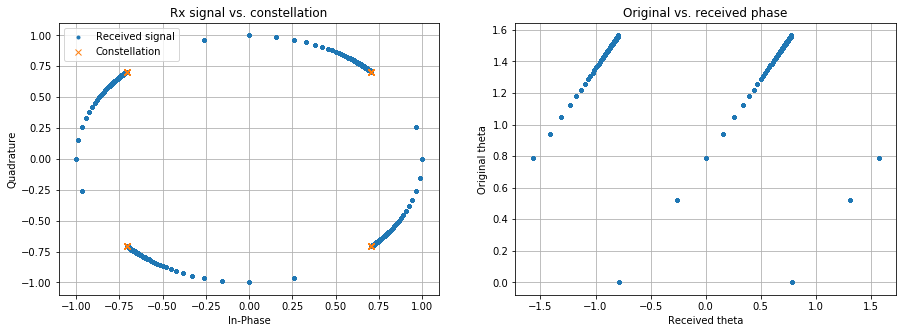

In [410]:
plt.figure(figsize=(15,5))

ax = plt.subplot(1, 2, 1)
plt.plot(y.real,y.imag,'.', label='Received signal')
plt.plot(s.real,s.imag,'x', label='Constellation')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.title('Rx signal vs. constellation')
plt.legend()
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(theta,theta_orig,'.')
plt.xlabel('Received theta')
plt.ylabel('Original theta')
plt.title('Original vs. received phase')
plt.grid()

plt.show()

In [411]:
# Split arrays into training and validation subsets.
theta_train, theta_test, theta_orig_train, theta_orig_test, y_train, y_test, ip_train, ip_test, s_train, s_test = train_test_split(theta, theta_orig.ravel(), y, ip, s, test_size=0.2, random_state=1)

In [412]:
# Instantiate MLP Regressor.
reg = MLPRegressor(hidden_layer_sizes=(10,5,4,2), random_state=1, max_iter=2000)
#reg = MLPRegressor(hidden_layer_sizes=(10,4), random_state=1, max_iter=2000) # SER: 0.0079 - score: 0.4361
#reg = MLPRegressor(hidden_layer_sizes=(10,5,2), random_state=1, max_iter=2000) # SER: 0.0079 - score: 0.4657
#reg = MLPRegressor(hidden_layer_sizes=(10,10,4), random_state=1, max_iter=2000) # SER: 0.0079 - score: 0.4414
#reg = MLPRegressor(hidden_layer_sizes=(10,5,4,2), random_state=1, max_iter=2000) # SER: 0.0079 - score: 0.4690
#reg = MLPRegressor(hidden_layer_sizes=(100,70,50,2), random_state=1, max_iter=2000) # SER: 0.0079 - score: 0.4687
#reg = MLPRegressor(hidden_layer_sizes=(400,280,200,2), random_state=1, max_iter=2000) # SER: 0.00715 - score: 0.4875
#reg = MLPRegressor(hidden_layer_sizes=(500,250,4), random_state=1, max_iter=2000) # SER: 0.00715 - score: 0.49

# Train MLP Regressor.
reg.fit(theta_train, theta_orig_train)

# Print number of training iterations.
print(reg.n_iter_)

15


In [413]:
# Print score.
print(reg.score(theta_test, theta_orig_test))

0.5720283603010798


In [414]:
# Predict phase over test set.
theta_pred = reg.predict(theta_test).reshape(len(theta_test), 1)

# Undo phase-shift.
y_rec = np.exp(1j*theta_pred)*y_test

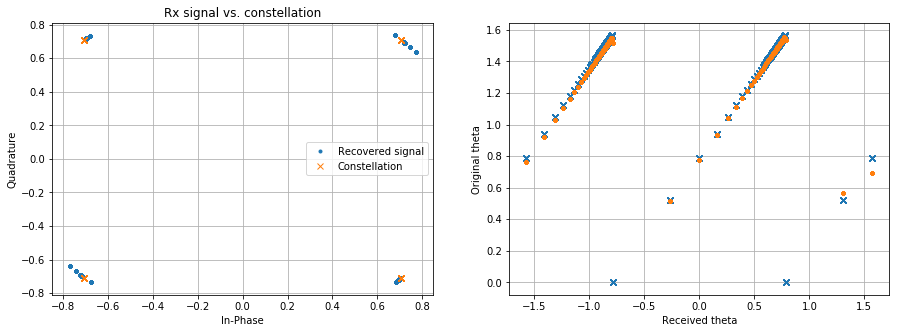

In [415]:
plt.figure(figsize=(15,5))

ax = plt.subplot(1, 2, 1)
plt.plot(y_rec.real, y_rec.imag,'.', label='Recovered signal')
plt.plot(s_test.real, s_test.imag,'x', label='Constellation')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.title('Rx signal vs. constellation')
plt.legend()
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(theta, theta_orig,'x')
plt.plot(theta_test, theta_pred,'.')
plt.xlabel('Received theta')
plt.ylabel('Original theta')
plt.grid()

plt.show()

In [416]:
# Simulated QPSK BER.
ip_test = ip_test.reshape(-1,)
error = 0
for i in range(0, len(y_rec)):
    d = demod(y_rec[i])
    if((ip_test[i] != d)==True): 
        error = error + 1
    
ser_simu = 1.0 * error / len(y_rec)

print('SER: ', ser_simu)

SER:  0.00188


# Lower SNR

In [417]:
# Generate different random phases.
M = 129
phase = np.exp(1j*np.pi/np.arange(2,M))

phase_rnd = np.zeros((N,1),dtype=np.complex_)
for i in range(0,N):
    phase_rnd[i] = phase[np.random.randint(len(phase))]
    
theta_orig = np.arctan(phase_rnd.real/phase_rnd.imag)

In [418]:
# Define Es/N0 value in dB.
EsN0dB = 30
# Tranform into linear value.
EsN0Lin = 10.0**(-(EsN0dB/10.0))
    
# Generate N binary symbols.
ip = np.random.randint(0,4,(N,1))
    
# Modulate binary stream into QPSK symbols.
s = mod(ip)
    
# Generate noise vector. 
# Divide by two once the theoretical ber uses a complex Normal pdf with variance of each part = 1/2.
noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))
    
# Add phase error and pass symbols through AWGN channel.
y = s*phase_rnd + np.sqrt(EsN0Lin)*noise

# Phase of received signal.
theta = np.arctan(y.real/y.imag)

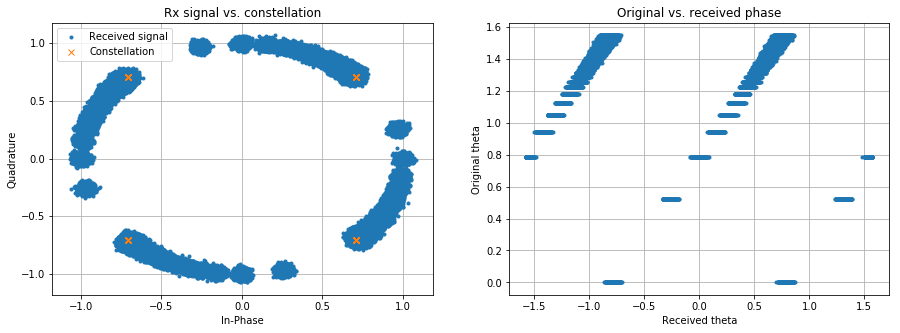

In [419]:
plt.figure(figsize=(15,5))

ax = plt.subplot(1, 2, 1)
plt.plot(y.real,y.imag,'.', label='Received signal')
plt.plot(s.real,s.imag,'x', label='Constellation')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.title('Rx signal vs. constellation')
plt.legend()
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(theta,theta_orig,'.')
plt.xlabel('Received theta')
plt.ylabel('Original theta')
plt.title('Original vs. received phase')
plt.grid()

plt.show()

In [420]:
# Split arrays into training and validation subsets.
theta_train, theta_test, theta_orig_train, theta_orig_test, y_train, y_test, ip_train, ip_test, s_train, s_test = train_test_split(theta, theta_orig.ravel(), y, ip, s, test_size=0.2, random_state=1)

In [421]:
# Predict phase over test set.
theta_pred = reg.predict(theta_test).reshape(len(theta_test), 1)

# Undo phase-shift.
y_rec = np.exp(1j*theta_pred)*y_test

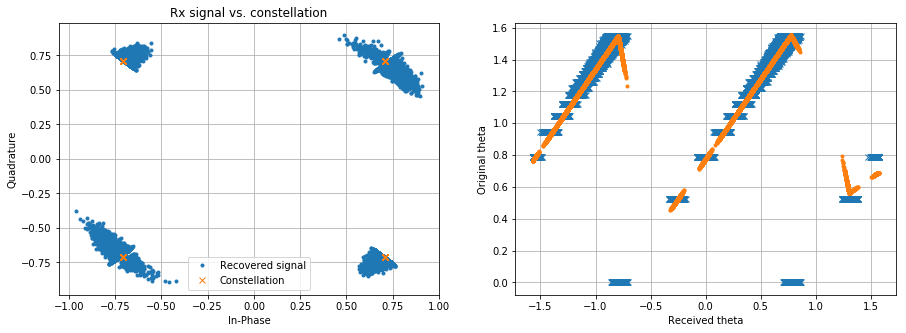

In [422]:
plt.figure(figsize=(15,5))

ax = plt.subplot(1, 2, 1)
plt.plot(y_rec.real, y_rec.imag,'.', label='Recovered signal')
plt.plot(s_test.real, s_test.imag,'x', label='Constellation')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.title('Rx signal vs. constellation')
plt.legend()
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(theta, theta_orig,'x')
plt.plot(theta_test, theta_pred,'.')
plt.xlabel('Received theta')
plt.ylabel('Original theta')
plt.grid()

plt.show()

In [423]:
# Simulated QPSK BER.
ip_test = ip_test.reshape(-1,)
error = 0
for i in range(0, len(y_rec)):
    d = demod(y_rec[i])
    if((ip_test[i] != d)==True): 
        error = error + 1
    
ser_simu = 1.0 * error / len(y_rec)

print('MLP SER: ', ser_simu)

# Simulated QPSK BER.
error = 0
for i in range(0, len(y_test)):
    d = demod(y_test[i])
    if((ip_test[i] != d)==True): 
        error = error + 1
    
ser_simu = 1.0 * error / len(y_test)

print('ORIG. SER: ', ser_simu)

MLP SER:  0.008185
ORIG. SER:  0.979735
